In [1]:

from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, LambdaCallback
from sklearn.metrics import confusion_matrix, classification_report
from keras.layers import Dropout, Dense, GlobalAveragePooling2D
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from keras.applications.resnet import ResNet50
from keras.utils import to_categorical
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
from keras.models import Model
from tensorflow import keras
import tensorflow as tf
import seaborn as sns
import numpy as np
import cv2
import os
import io

2023-10-12 21:01:58.906226: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
labels = ['glioma', 'meningioma', 'no_tumor', 'pituitary']
testing_path = 'Testing/'
training_path = 'Training/'
image_size = 200

In [3]:
def augment_image_file(file):
    image = cv2.imread(file, 0) 
    image = cv2.bilateralFilter(image, 2, 50, 50)
    image = cv2.applyColorMap(image, cv2.COLORMAP_BONE)
    image = cv2.resize(image, (image_size, image_size))
    return image

In [4]:
def load_data(path, labels):
    X, y = [], []
    for label in labels:
        label_path = os.path.join(path, label)
        for file in os.listdir(label_path):
            image = augment_image_file(os.path.join(label_path, file))
            X.append(image)
            y.append(labels.index(label))
    return np.array(X) / 255.0, y

X_train, y_train = load_data(training_path, labels)
X_test, y_test = load_data(testing_path, labels)


In [5]:
X_train, y_train = shuffle(X_train, y_train, random_state=42)

y_train = to_categorical(y_train) # One-hot encoding of integer labels
y_test = to_categorical(y_test)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42) # 20% of the data is validation data

In [6]:
image_gen = ImageDataGenerator(
    rotation_range=10,                        
    width_shift_range=0.05,
    height_shift_range=0.05,
    horizontal_flip=True,
)

image_gen.fit(X_train)

In [7]:
resnet = ResNet50(
    weights='imagenet',
    include_top=False,
    input_shape=(image_size, image_size, 3)
)

In [8]:
model = resnet.output
model = GlobalAveragePooling2D()(model)
model = Dropout(0.4)(model)
model = Dense(4, activation='softmax')(model)
model = Model(inputs=resnet.input, outputs=model)

adam = keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=adam, loss = 'categorical_crossentropy', metrics=['accuracy', 'AUC'])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 200, 200, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 206, 206, 3)          0         ['input_1[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 100, 100, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 100, 100, 64)         256       ['conv1_conv[0][0]']          
 on)                                                                                          

In [9]:
class_names = list(labels)

# Convert a matplotlib figure to a TensorFlow image tensor.
def plot_to_image(figure):
    with io.BytesIO() as buffer:
        plt.savefig(buffer, format='png')
        plt.close(figure)
        buffer.seek(0)
        digit = tf.image.decode_png(buffer.read(), channels=4)
    # Expand the dimensions so it fits the expected TF image format [1, H, W, C].
    return tf.expand_dims(digit, 0)

# Create a matplotlib plot of the confusion matrix.
def plot_confusion_matrix(cm, class_names):
    # Normalize the confusion matrix for better readability.
    cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    figure = plt.figure(figsize=(8, 8))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Accent)
    plt.colorbar()
    plt.xticks(np.arange(len(class_names)), class_names, rotation=45)
    plt.yticks(np.arange(len(class_names)), class_names)
    plt.title('Confusion matrix')
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
    # Add normalized values as text on the cells.
    threshold = cm.max() / 2.0
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            if cm[i, j] > threshold:
                color = 'white'
            else:
                color = 'black'
            
            text_value = "{:.2f}".format(cm_norm[i, j])
            plt.text(j, i, text_value, horizontalalignment='center', color=color)

    
    plt.tight_layout()
    return figure

# Display the confusion matrix using 
# TensorFlow summary after each epoch.
def display_conf_matrix(epoch, logs):
    # Get the model's prediction on the test data.
    pred = np.argmax(model.predict(X_test), axis=1)

    cm = confusion_matrix(np.argmax(y_test, axis=1), pred)

    figure = plot_confusion_matrix(cm, class_names)
    _ = plot_to_image(figure)


In [11]:
BATCH_SIZE = 64
EPOCHS = 30

checkpoint = ModelCheckpoint(filepath='model.h5', monitor='val_loss', verbose=1, save_best_only=True, mode='min')

early_stopping = EarlyStopping(monitor='val_loss', min_delta=0.001, patience=5, mode='min', restore_best_weights=True, verbose=1)

scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=5, verbose=1, mode='min')

callbacks = [
    early_stopping, 
    scheduler, 
    checkpoint, 
    LambdaCallback(on_epoch_end=display_conf_matrix)
]

history = model.fit(
    image_gen.flow(
        X_train, y_train, batch_size=20
    ),
    validation_data=(X_val, y_val),
    epochs=EPOCHS,
    callbacks=callbacks
)


Epoch 1/30
511/511 [==============================] - ETA: 0s - loss: 0.1503 - accuracy: 0.9507 - auc: 0.9948
Epoch 1: val_loss improved from inf to 0.33947, saving model to model.h5


/Users/adisveletanlic/git/brain-tumor-classifier/.venv/lib/python3.11/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


511/511 [==============================] - 1727s 3s/step - loss: 0.1503 - accuracy: 0.9507 - auc: 0.9948 - val_loss: 0.3395 - val_accuracy: 0.8857 - val_auc: 0.9787 - lr: 1.0000e-04
Epoch 2/30
511/511 [==============================] - ETA: 0s - loss: 0.0902 - accuracy: 0.9705 - auc: 0.9979
Epoch 2: val_loss improved from 0.33947 to 0.13410, saving model to model.h5


/Users/adisveletanlic/git/brain-tumor-classifier/.venv/lib/python3.11/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


511/511 [==============================] - 1508s 3s/step - loss: 0.0902 - accuracy: 0.9705 - auc: 0.9979 - val_loss: 0.1341 - val_accuracy: 0.9565 - val_auc: 0.9953 - lr: 1.0000e-04
Epoch 3/30
511/511 [==============================] - ETA: 0s - loss: 0.0685 - accuracy: 0.9781 - auc: 0.9984
Epoch 3: val_loss improved from 0.13410 to 0.08313, saving model to model.h5


/Users/adisveletanlic/git/brain-tumor-classifier/.venv/lib/python3.11/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


511/511 [==============================] - 1615s 3s/step - loss: 0.0685 - accuracy: 0.9781 - auc: 0.9984 - val_loss: 0.0831 - val_accuracy: 0.9702 - val_auc: 0.9984 - lr: 1.0000e-04
Epoch 4/30
511/511 [==============================] - ETA: 0s - loss: 0.0656 - accuracy: 0.9791 - auc: 0.9983
Epoch 4: val_loss improved from 0.08313 to 0.08068, saving model to model.h5


/Users/adisveletanlic/git/brain-tumor-classifier/.venv/lib/python3.11/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


511/511 [==============================] - 1739s 3s/step - loss: 0.0656 - accuracy: 0.9791 - auc: 0.9983 - val_loss: 0.0807 - val_accuracy: 0.9773 - val_auc: 0.9968 - lr: 1.0000e-04
Epoch 5/30
511/511 [==============================] - ETA: 0s - loss: 0.0523 - accuracy: 0.9845 - auc: 0.9986
Epoch 5: val_loss did not improve from 0.08068
511/511 [==============================] - 1642s 3s/step - loss: 0.0523 - accuracy: 0.9845 - auc: 0.9986 - val_loss: 0.1632 - val_accuracy: 0.9565 - val_auc: 0.9922 - lr: 1.0000e-04
Epoch 6/30
511/511 [==============================] - ETA: 0s - loss: 0.0419 - accuracy: 0.9863 - auc: 0.9992
Epoch 6: val_loss did not improve from 0.08068
511/511 [==============================] - 1463s 3s/step - loss: 0.0419 - accuracy: 0.9863 - auc: 0.9992 - val_loss: 0.1103 - val_accuracy: 0.9632 - val_auc: 0.9958 - lr: 1.0000e-04
Epoch 7/30
511/511 [==============================] - ETA: 0s - loss: 0.0456 - accuracy: 0.9836 - auc: 0.9993
Epoch 7: val_loss improved fro

/Users/adisveletanlic/git/brain-tumor-classifier/.venv/lib/python3.11/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


511/511 [==============================] - 1522s 3s/step - loss: 0.0456 - accuracy: 0.9836 - auc: 0.9993 - val_loss: 0.0617 - val_accuracy: 0.9828 - val_auc: 0.9979 - lr: 1.0000e-04
Epoch 8/30
511/511 [==============================] - ETA: 0s - loss: 0.0514 - accuracy: 0.9853 - auc: 0.9989
Epoch 8: val_loss did not improve from 0.06169
511/511 [==============================] - 1454s 3s/step - loss: 0.0514 - accuracy: 0.9853 - auc: 0.9989 - val_loss: 0.1141 - val_accuracy: 0.9699 - val_auc: 0.9954 - lr: 1.0000e-04
Epoch 9/30
511/511 [==============================] - ETA: 0s - loss: 0.0365 - accuracy: 0.9873 - auc: 0.9994
Epoch 9: val_loss did not improve from 0.06169
511/511 [==============================] - 1482s 3s/step - loss: 0.0365 - accuracy: 0.9873 - auc: 0.9994 - val_loss: 0.1992 - val_accuracy: 0.9569 - val_auc: 0.9907 - lr: 1.0000e-04
Epoch 10/30
511/511 [==============================] - ETA: 0s - loss: 0.0470 - accuracy: 0.9855 - auc: 0.9988
Epoch 10: val_loss did not im

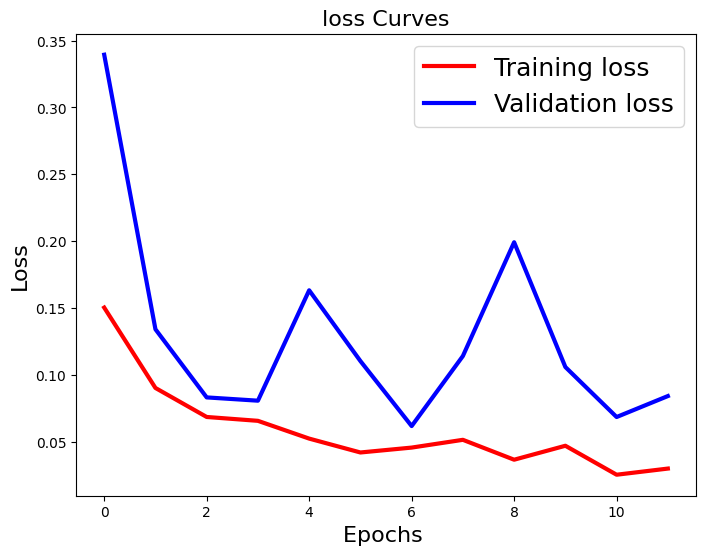

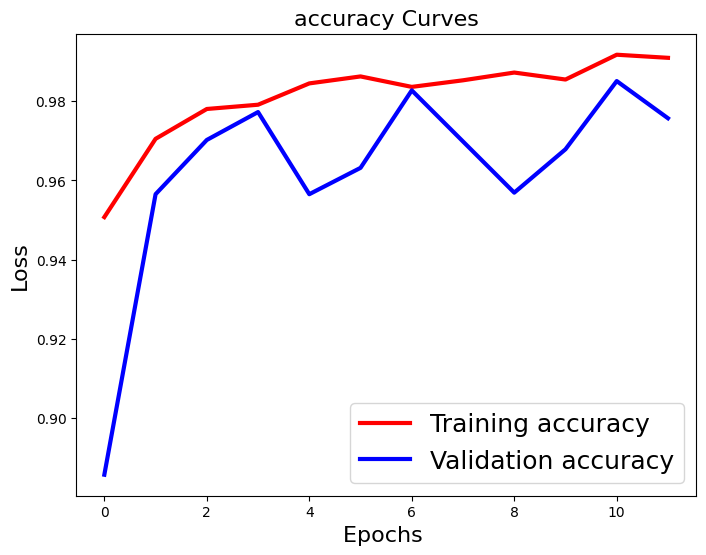

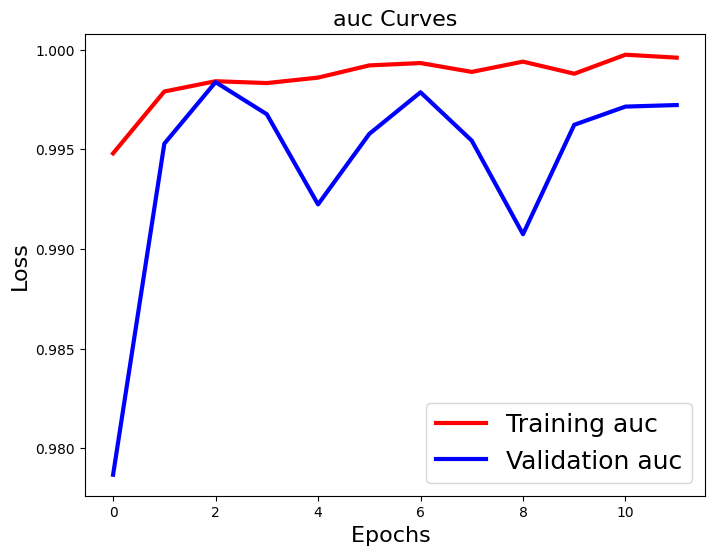

In [12]:
def plot(metric):
    plt.figure(figsize=[8,6])
    plt.plot(history.history[metric], 'r', linewidth=3.0)
    plt.plot(history.history[f'val_{metric}'], 'b', linewidth=3.0)
    plt.legend([f'Training {metric}', f'Validation {metric}'], fontsize=18)
    plt.xlabel('Epochs ', fontsize=16)
    plt.ylabel('Loss', fontsize=16)
    plt.title(f'{metric} Curves', fontsize=16)
    plt.show()
    
plot('loss')
plot('accuracy')
plot('auc')

54/54 [==============================] - 54s 996ms/step
              precision    recall  f1-score   support

           0       0.99      0.92      0.96       399
           1       0.94      0.98      0.96       421
           2       0.97      1.00      0.98       510
           3       0.98      0.98      0.98       374

    accuracy                           0.97      1704
   macro avg       0.97      0.97      0.97      1704
weighted avg       0.97      0.97      0.97      1704



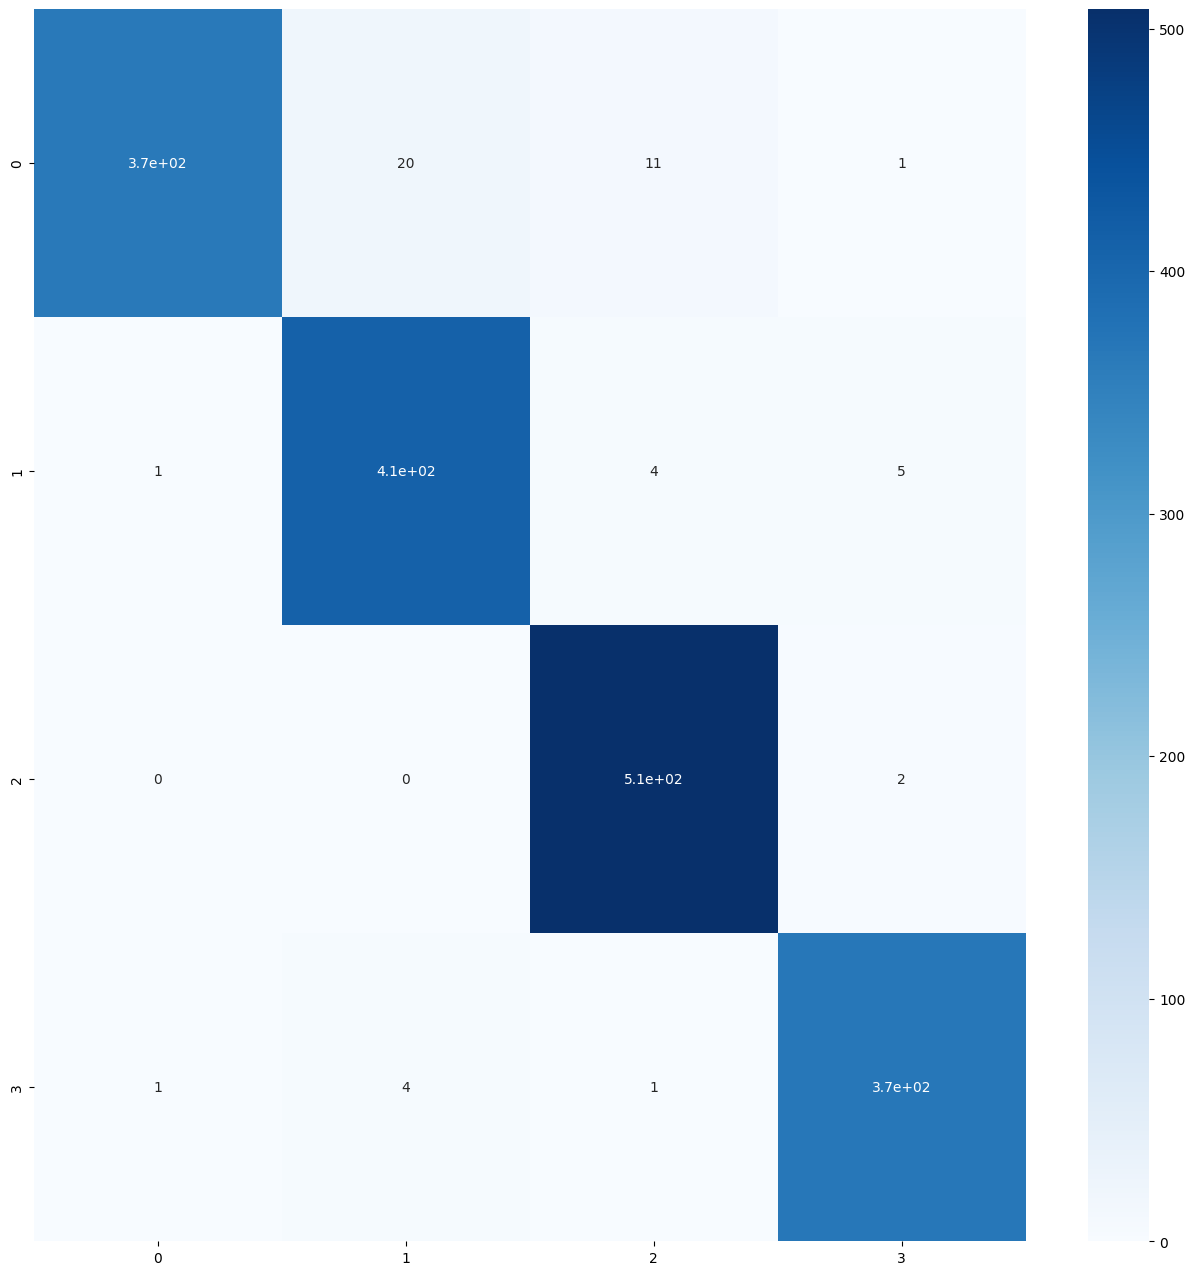

In [13]:
predicted_classes = np.argmax(model.predict(X_test), axis=1)
confusionmatrix = confusion_matrix(np.argmax(y_test,axis=1), predicted_classes)
plt.figure(figsize = (16, 16))
sns.heatmap(confusionmatrix, cmap='Blues', annot=True, cbar=True)
print(classification_report(np.argmax(y_test,axis=1), predicted_classes))

In [14]:
loss, acc, auc = model.evaluate(X_test, y_test)

54/54 [==============================] - 52s 958ms/step - loss: 0.1415 - accuracy: 0.9707 - auc: 0.9941
